# Trabajo Practico #0 - Algoritmo de Maxima Verosimilitud de Kittler

## Grupo de Trabajo:
- Sophia Contreras
- Yoksan Varela
- Mauro Viquez

## Librerias

In [1]:
import torch
import requests
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from io import BytesIO
from PIL import Image
%matplotlib inline

# Para remover Warnings
import warnings
warnings.filterwarnings("ignore")

# Para Pruebas unitarias
import ipytest
ipytest.autoconfig()

## Funciones Generales

In [2]:
def importar_objecto(url,tipo = "i"):
    """
    Funcion para poder importar objectos de imagen o audio
    Args:
        url (str): URL del objecto a ser importado
        tipo (str): valores aceptados: "i" = imagen (por defecto), "a" = audio
    """
    objecto_raw = requests.get(url)
    if(tipo == "i"):
        imagen = Image.open(BytesIO(objecto_raw.content)).convert('L')
        return imagen
    if(tipo == "a"):
        samplerate, data = wavfile.read(BytesIO(objecto_raw.content))
        return samplerate, data

def plot_bar(bins, histogram, axis_x_label, axis_y_label, title):
    """Funcion para hacer el plot histogramas"""
    plt.figure()
    plt.bar(bins[:-1], histogram, color ='maroon', edgecolor='k')
    plt.xlabel(axis_x_label)
    plt.ylabel(axis_y_label)
    plt.title(title)
    plt.show()
    
def gaus_den_func(MarginalProb,value,mean,stddev):
    """Funcion de la densidad de probabilidad gaussiana"""
    # Dividiendo la ecuacion por secciones para facilitar la implementacion
    magnitud = 1/(stddev*torch.sqrt(torch.tensor(2*torch.pi)))
    exp_1 = -1/(2*torch.float_power(torch.tensor(stddev),2))
    exp_2 = torch.float_power(torch.tensor(value-mean),2)
    exponencial = torch.exp(exp_1*exp_2)
    
    # Finalmente, se completa la operacion de la funcion de densidad gaussiana
    p_value = MarginalProb*magnitud*exponencial
    
    return p_value

## Seccion 1.A: Funcion calcular_momentos_estadisticos

In [3]:
# Funcion toma como parametros T y p
def calcular_momentos_estadisticos(T,p):
    """ 
        Funcion para calcular los momentos estadisticos: P1, P2, mean1, mean2, std1 y std2
        Recibe T que es umbral candidato a ser evaluado, el cual se usara para partir la funcion de densidad en dos.
        p es una funcion de densidad normalizada
    """
    # Creando dos arreglos, divididos por T
    p_1 = p[0:T]
    p_2 = p[T+1:len(p)]
    
    # Calculando las Probabilidades Marginales
    P1 = p_1.sum()
    P2 = p_2.sum()
    
    # Calculando las medias
    bins1 = np.arange(0,T)
    mean1 = (np.dot(p_1,bins1))/(P1)
    
    bins2 = np.arange(T+1,len(p))
    mean2 = (np.dot(p_2,bins2))/(P2)

    # Calculando las desviaciones estandar
    var1=(np.dot(p_1,torch.float_power(torch.tensor(bins1-mean1),2)))/(P1)
    var2=(np.dot(p_2,torch.float_power(torch.tensor(bins2-mean2),2)))/(P2)

    # Ya con todos los momentos estadisticos calculados, se retornan
    return round(P1,3),round(P2,3),round(mean1,3),round(mean2,3),round(var1,3),round(var2,3)

### Seccion 1.A.1: Pruebas unitarias para la funcion calcular_momentos_estadisticos

In [4]:
%%ipytest

# Condiciones de prueba para la funcion calcular_momentos_estadisticos. NOTA: Hay que correr el notebook al menos una vez para que este codigo funcione
T = 180
P_1,P_2,m_1,m_2,var_1,var_2 = calcular_momentos_estadisticos(T,hist_norm_imagen)

def test_calcular_momentos_estadisticos_Pesos() -> None:
    # Primera prueba unitaria: La suma de P1 + P2 tiene que ser igual a 1
    assert P_1 + P_2 == 1

def test_calcular_momentos_estadisticos_verosimilidad_menor() -> None:
    # Segunda prueba unitaria: La verosimilitud cuando z < T implica que P1*p(z|m1,v1,P1) > P2*p(z|m2,v2,P2)
    z = 140
    assert gaus_den_func(P_1,z,m_1,torch.sqrt(torch.tensor(var_1))) >= gaus_den_func(P_2,z,m_2,torch.sqrt(torch.tensor(var_2)))
    
def test_calcular_momentos_estadisticos_verosimilidad_mayor() -> None:
    # Tercera prueba unitaria: La verosimilitud cuando z > T implica que P1*p(z|m1,v1,P1) < P2*p(z|m2,v2,P2)
    z = 210
    assert gaus_den_func(P_1,z,m_1,torch.sqrt(torch.tensor(var_1))) <= gaus_den_func(P_2,z,m_2,torch.sqrt(torch.tensor(var_2)))
    

NameError: name 'hist_norm_imagen' is not defined


no tests ran in 0.00s


## Seccion 1.B: Funcion *calcular_costo_J(T)*

Ya con la funcion *calcular_momentos_estadisticos(T,p)* se pueden calcular todas las variables necesarias por esta funcion. Primero, se crea la funcion con todos los parametros necesarios.

In [5]:
def calcular_costo_J_T(P1,Var1,P2,Var2):
    """
    Funcion para calcular el costo J de la funcion de Kittler
    Args:
        P1,P2 (float): Pesos de las dos funciones de densidad Gaussianas
        Var1,Var2(float): Varianzas de las funciones de densidad Gaussianas
    """
    if(np.isnan(Var1) or np.isnan(Var2) or Var1 == 0 or Var2 == 0): # Si T no esta en medio de la dos distribuciones, la desviacion estandar de alguna de las dos funciones es NaN
        return 10
    parte1 = 2*((P1*torch.log(torch.tensor(torch.sqrt(torch.tensor(Var1)))))+(P2*torch.log(torch.tensor(torch.sqrt(torch.tensor(Var2))))))
    parte2 = 2*((P1*torch.log(torch.tensor(P1)))+(P2*torch.log(torch.tensor(P2))))
    J_T = 1 + parte1 - parte2
    return J_T

### Seccion 1.B.1: Pruebas unitarias para la funcion calcular_costo_J_T

In [6]:
%%ipytest

# NOTA: Hay que correr el notebook al menos una vez para que este codigo funcione

def test_calcular_costo_J_T_EnMedio() -> None:
    # Primera prueba unitaria: Si T esta en medio de las dos funciones de densidad gaussiana, la funcion debe retornar un valor mayor a 0
    T = 180
    P_1,P_2,m_1,m_2,var_1,var_2 = calcular_momentos_estadisticos(T,hist_norm_imagen)
    assert calcular_costo_J_T(P_1,var_1,P_2,var_2) > 0

def test_calcular_costo_J_T_Afuera() -> None:
    # Segunda prueba unitaria: Si T esta antes o despues de las dos funciones de densidad gaussiana, la funcion debe retornar un NaN
    T = 100
    P_1,P_2,m_1,m_2,var_1,var_2 = calcular_momentos_estadisticos(T,hist_norm_imagen)
    assert calcular_costo_J_T(P_1,var_1,P_2,var_2) == 10

FF                                                                                           [100%]
============================================ FAILURES =============================================
_________________________________ test_calcular_costo_J_T_EnMedio _________________________________

    def test_calcular_costo_J_T_EnMedio() -> None:
        # Primera prueba unitaria: Si T esta en medio de las dos funciones de densidad gaussiana, la funcion debe retornar un valor mayor a 0
        T = 180
>       P_1,P_2,m_1,m_2,var_1,var_2 = calcular_momentos_estadisticos(T,hist_norm_imagen)
E       NameError: name 'hist_norm_imagen' is not defined

C:\Users\yoksa\AppData\Local\Temp\ipykernel_12756\3519810544.py:6: NameError
_________________________________ test_calcular_costo_J_T_Afuera __________________________________

    def test_calcular_costo_J_T_Afuera() -> None:
        # Segunda prueba unitaria: Si T esta antes o despues de las dos funciones de densidad gaussiana, la funcio

## Seccion 1.C: Funcion *calcular_T_optimo_Kittler*

Esta funcion va a retornar el valor optimo de T para umbralizar una imagen, y a la vez, umbralizarla.

In [7]:
def calcular_T_optimo_Kittler(vec_object,cantidad_bins,inicio_range,final_range):
    # 1. Creando un arreglo del vector objecto
    arr_object = vec_object.ravel()

    # 2. Crear un histograma normalizado del objecto, usando la cantidad de bines y sus respectivos rangos
    hist_obj, bins_obj = np.histogram(arr_object, bins = cantidad_bins, range=(inicio_range,final_range))
    hist_norm_obj = hist_obj/hist_obj.sum()

    # 3. Empezando con T=0, encontrar el valor optimo para umbralizar
    T = 0
    error_menor = 100
    T_menor = 0
    for T in range (cantidad_bins):
        # Calculando los momentos estadisticos
        P_1,P_2,m_1,m_2,var_1,var_2 = calcular_momentos_estadisticos(T,hist_norm_obj)

        # Calculando el error
        error_temporal = calcular_costo_J_T(P_1,var_1,P_2,var_2)
        if(error_temporal < error_menor):
            error_menor = error_temporal
            T_menor = T
    
    # 4. Umbralizar
    tmp_vec = vec_object.numpy()
    tmp_vec[tmp_vec > T_menor] = 255
    tmp_vec[tmp_vec < T_menor] = 0

    return T_menor,tmp_vec
    


El T optimo calculado es T=206
Imagen umbralizada:


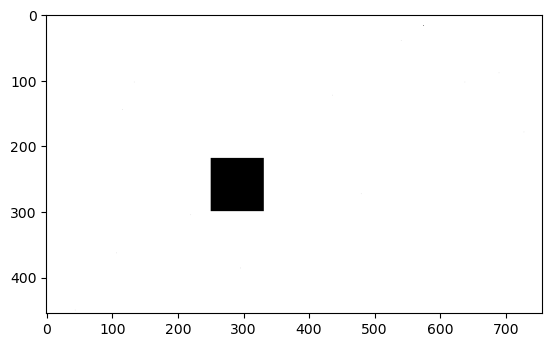

In [8]:
url_imagen = 'https://raw.githubusercontent.com/YoksanVC/TEC_DataScienceCert/main/Module_3_Estadistica_CienciaDatos/Trabajo_Practico_0_Kittler/Documentos_Dropbox/input/cuadro1_005.bmp'
imagen = importar_objecto(url_imagen,"i")
vector_imagen = torch.tensor(np.array(imagen))
T_optimo, nuevo_vector = calcular_T_optimo_Kittler(vector_imagen,256,0,256)

# Imprimiendo nueva imagen
# Mostrando imagen
print(f"El T optimo calculado es T={T_optimo}")
print("Imagen umbralizada:")
plt.imshow(nuevo_vector, cmap = 'gray')
plt.show()


## Seccion 1.D: Aplique el algoritmo de Kittler en la imagen *cuadro1_005.bmp* provista.
### 1.D.1: Grafique el histograma normalizado de la imagen de entrada provista.

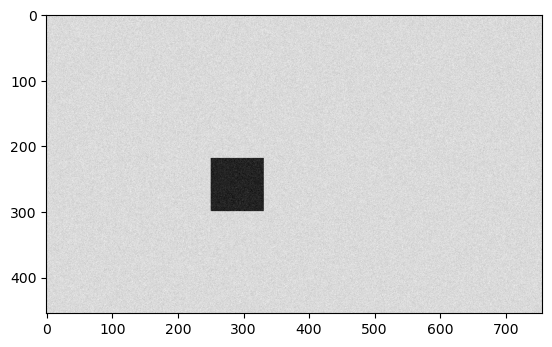

In [9]:
# URL imagen cuadro1_005.bmp
url_imagen = 'https://raw.githubusercontent.com/YoksanVC/TEC_DataScienceCert/main/Module_3_Estadistica_CienciaDatos/Trabajo_Practico_0_Kittler/Documentos_Dropbox/input/cuadro1_005.bmp'

# Creando imagen
imagen = importar_objecto(url_imagen,"i")

# Mostrando imagen
plt.imshow(imagen, cmap = 'gray')
plt.show()


In [10]:
# Creando una matriz con la imagen
vector_imagen = torch.tensor(np.array(imagen))
print(vector_imagen.shape)

torch.Size([455, 756])


tensor([219, 218, 219,  ..., 221, 225, 224], dtype=torch.uint8)


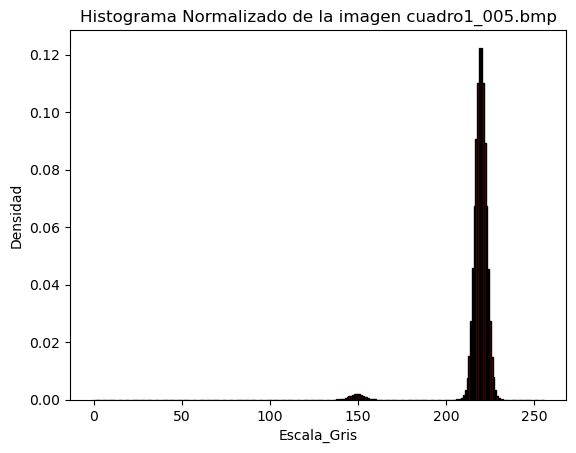

In [11]:
# Creando un array de la matriz con la funcion ravel de Numpy
array_imagen = vector_imagen.ravel()
print(array_imagen)

# Creando un histograma del arreglo anterior y normalizandolo
hist_imagen, bins_imagen = np.histogram(array_imagen, bins = 256, range=(0,256))
hist_norm_imagen = hist_imagen/hist_imagen.sum()

# Imprimir el histograma de la imagen
plot_bar(bins_imagen,hist_norm_imagen,"Escala_Gris","Densidad","Histograma Normalizado de la imagen cuadro1_005.bmp")

### 1.D.2: Grafique la función J(T), y documente el valor T = τ que logra el valor mínimo de J(T), junto con las medias y varianzas de las dos funciones Gaussianas superpuestas

Valor T | Costo | Media 1 | Var 1 | Media 2 | Var 2
---------------------------------------------------
143 | 5.568110496363331 | 140.85 | 1.939 | 218.246 | 95.22
144 | 5.521360449822795 | 141.749 | 2.253 | 218.303 | 91.082
145 | 5.465752360560687 | 142.637 | 2.575 | 218.383 | 85.315
146 | 5.390241282201578 | 143.488 | 2.934 | 218.48 | 78.384
147 | 5.288779384717029 | 144.26 | 3.375 | 218.594 | 70.337
148 | 5.169029307563772 | 144.992 | 3.944 | 218.723 | 61.338
149 | 5.0245119633155655 | 145.695 | 4.643 | 218.856 | 52.176
150 | 4.8540739127803825 | 146.342 | 5.453 | 218.987 | 43.222
151 | 4.660826464413697 | 146.94 | 6.392 | 219.11 | 34.91
152 | 4.43890989465325 | 147.485 | 7.45 | 219.219 | 27.658
153 | 4.230344565940637 | 147.968 | 8.601 | 219.305 | 21.972
154 | 4.025821830717871 | 148.367 | 9.766 | 219.371 | 17.675
155 | 3.8390478736891005 | 148.692 | 10.93 | 219.421 | 14.473
156 | 3.7249409614838336 | 148.96 | 12.083 | 219.449 | 12.751
157 | 3.6150023343042004 | 149.122 | 12.917 | 2

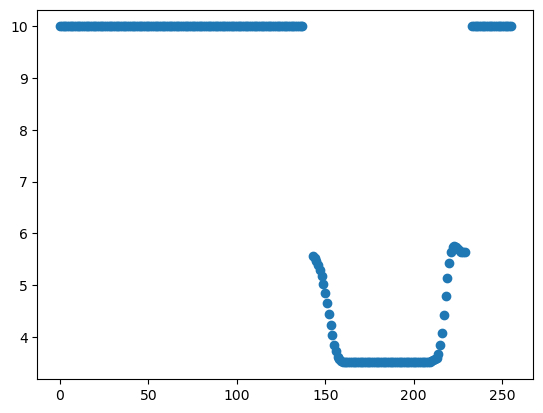

In [18]:
# Creando el eje X para crear la grafica de J(T)
eje_x = np.arange(0,256)
valores_J_T = []

T = 0
print("Valor T | Costo | Media 1 | Var 1 | Media 2 | Var 2")
print("---------------------------------------------------")
for T in range(len(eje_x)):
    # Creando los momentos estadisticos
    P_1,P_2,m_1,m_2,var_1,var_2 = calcular_momentos_estadisticos(T,hist_norm_imagen)

    # Obteniendo los valores de J(T) para cada valor de T
    costo = calcular_costo_J_T(P_1,var_1,P_2,var_2)
    if(0 < costo < 10):
        print(f"{T} | {costo} | {m_1} | {var_1} | {m_2} | {var_2}")
    valores_J_T.append(costo)

plt.scatter(eje_x,valores_J_T)
plt.show()


In [13]:
# Llamando a la funcion calcular_momentos_estadisticos
T=137
P_1,P_2,m_1,m_2,sd_1,sd_2 = calcular_momentos_estadisticos(T,hist_norm_imagen)

print(f"Para la primera distribucion, la probabilidad marginal es {P_1}, la media es {m_1} y la desviacion estandar es {sd_1}")
print(f"Para la segunda distribucion, la probabilidad marginal es {P_2}, la media es {m_2} y la desviacion estandar es {sd_2}")

Para la primera distribucion, la probabilidad marginal es 0.0, la media es 136.0 y la desviacion estandar es 0.0
Para la segunda distribucion, la probabilidad marginal es 1.0, la media es 218.158 y la desviacion estandar es 101.828


In [14]:
# Probando funcion calcular_costo_J_T
t_value = calcular_costo_J_T(P_1,sd_1,P_2,sd_2)
print(f"Valor de J(T):\n{t_value}")

Valor de J(T):
10


## Seccion 1.E: Probar la implementacion del algoritmo de Kittler con el audio *contamindated_audio.wav*
### Parte 1: Grafique el histograma del audio y argumente si es apropiado usar este algoritmo.

In [15]:
# Importando el archivo de audio de GitHub
url_audio = 'https://github.com/YoksanVC/TEC_DataScienceCert/raw/main/Module_3_Estadistica_CienciaDatos/Trabajo_Practico_0_Kittler/Documentos_Dropbox/input/contaminated_audio.wav'

sample_rate,data = importar_objecto(url_audio,"a")

# Imprimiendo informacion importante del audio
print(sample_rate)
print(data.shape)
print(len(data))

16000
(252138,)
252138


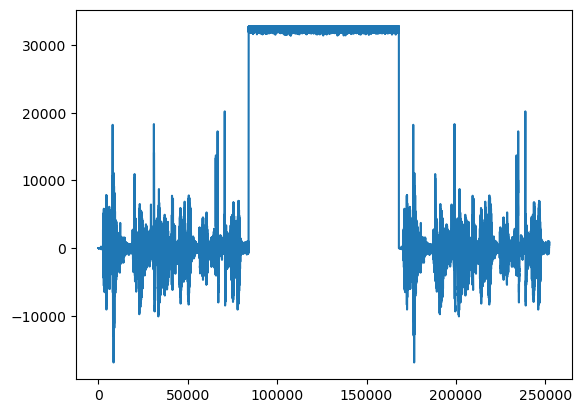

In [16]:
plt.plot(data)
plt.show()

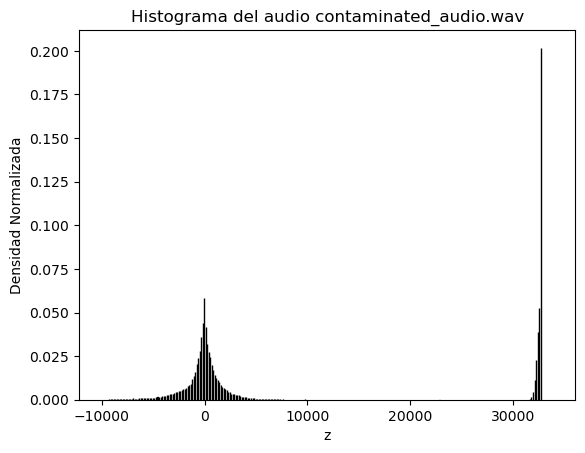

In [17]:
# Graficando el histograma del audio normalizado
hist_audio, bins_audio = np.histogram(data, bins = 300, range=(-10000,34000))
hist_audio_norm = hist_audio/hist_audio.sum()
plot_bar(bins_audio,hist_audio_norm,"z","Densidad Normalizada","Histograma del audio contaminated_audio.wav")

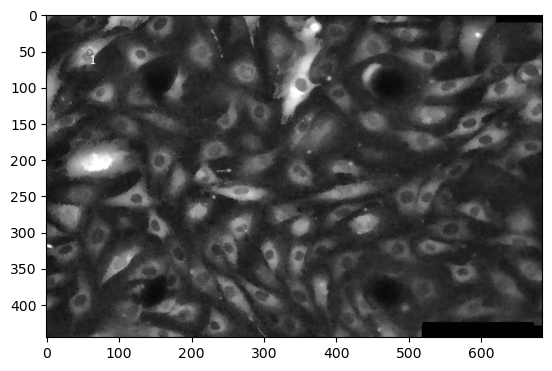

In [21]:
url_imagen2 = 'https://raw.githubusercontent.com/YoksanVC/TEC_DataScienceCert/main/Module_3_Estadistica_CienciaDatos/Trabajo_Practico_0_Kittler/Documentos_Dropbox/input/trackedCell15.bmp'
imagen2 = importar_objecto(url_imagen2,"i")

plt.imshow(imagen2, cmap = 'gray')
plt.show()


El T optimo calculado es T=88
Imagen umbralizada:


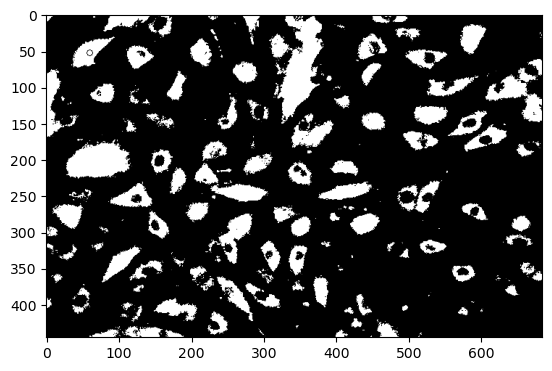

In [22]:
vector_imagen2 = torch.tensor(np.array(imagen2))
T_optimo2, nuevo_vector2 = calcular_T_optimo_Kittler(vector_imagen2,256,0,256)

# Imprimiendo nueva imagen
# Mostrando imagen
print(f"El T optimo calculado es T={T_optimo2}")
print("Imagen umbralizada:")
plt.imshow(nuevo_vector2, cmap = 'gray')
plt.show()